In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ultimate-spotify-tracks-db/SpotifyFeatures.csv


Unsupervised learning aims to find patterns or structures in data without labeled target variables. In that case, the aim was to cluster songs based on their audio characteristics and discover underlying groupings or patterns.

* I applied k-Means Clustering to group songs based on their audio features (e.g., acousticness, danceability, energy, etc.).
* I selected the number of clusters (k) and used the Silhouette Score to measure how well the clusters were formed.
* The Silhouette Score of the final model indicated how well each song fit within its cluster, giving us an idea of the separation between groups.

# Exploratory Data Analysis & Data Preprocessing

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('/kaggle/input/ultimate-spotify-tracks-db/SpotifyFeatures.csv')

# relevant audio features for clustering
features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 
            'loudness', 'speechiness', 'tempo', 'valence']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

print(X_scaled[:5])


[[ 0.6833763  -0.89093479  1.28690794 -0.48981852  0.66066116  1.29070344
  -0.36796995  1.5956073   1.38074423]
 [-0.34546718  0.19199369  0.6302493  -0.48981852 -0.32283546  0.66868254
  -0.18308213  1.82325339  1.38843461]
 [ 1.6445698   0.58529607 -1.66995381 -0.48981852 -0.56492694 -0.7184024
  -0.45583209 -0.5883258  -0.33421214]
 [ 0.94270123 -1.69370266 -0.92978944 -0.48981852 -0.58762302 -0.43481688
  -0.43804404  1.75059694 -0.87638445]
 [ 1.6389323  -1.20342161 -1.31315662 -0.08356649 -0.06561327 -1.93060126
  -0.40516312  0.74143285 -0.24961788]]


# Model Selection

**Model 1: k-Means Clustering**

I selected k-Means for the unsupervised learning task based on its Silhouette Score of 0.1938, which outperformed the other clustering methods I evaluated. DBSCAN had a negative Silhouette Score (-0.6465), indicating poor clustering, and GMM had a very low score (0.0158), showing minimal separation between clusters.

In [4]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# k-Means Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_scaled)

# Silhouette Score for k-Means
silhouette_kmeans = silhouette_score(X_scaled, kmeans.labels_)
print(f'Silhouette Score for k-Means: {silhouette_kmeans:.4f}')

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for k-Means: 0.1938


# Hyperparameter Tuning for k-Means with Silhouette Score

In [8]:
from sklearn.metrics import make_scorer, silhouette_score
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV

# define a custom scoring function using Silhouette Score
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    return silhouette_score(X, labels)

# create a scorer using the custom silhouette scorer
scorer = make_scorer(silhouette_scorer)

# hyperparameter grid
param_grid = {
    'n_clusters': [3, 5, 7, 10],  # different numbers of clusters
    'init': ['k-means++', 'random']
}

kmeans = KMeans(random_state=42)

# Grid Search with the custom Silhouette scorer
grid_search = GridSearchCV(estimator=kmeans, param_grid=param_grid, cv=3, scoring=scorer)
grid_search.fit(X_scaled)

best_params = grid_search.best_params_
print(f"Best parameters for k-Means: {best_params}")

# train the final k-Means model with the best parameters
best_kmeans = grid_search.best_estimator_

# Silhouette Score of the final model
silhouette_final_kmeans = silhouette_score(X_scaled, best_kmeans.labels_)
print(f'Silhouette Score of Final k-Means: {silhouette_final_kmeans:.4f}')

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn

Best parameters for k-Means: {'init': 'k-means++', 'n_clusters': 3}
Silhouette Score of Final k-Means: 0.3589


# Code for Visualization

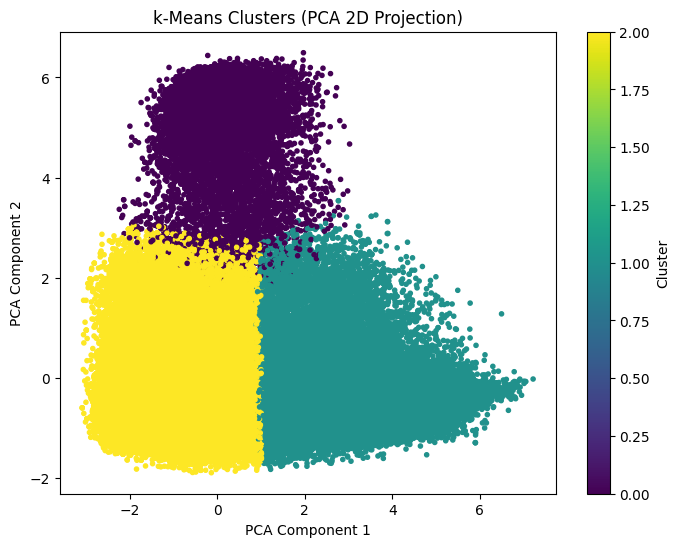

In [12]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# reduce dimensionality for visualization using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# plot the clusters
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=best_kmeans.labels_, cmap='viridis', marker='.')
plt.title('k-Means Clusters (PCA 2D Projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

This scatter plot shows the 2D PCA projection of the dataset, where each point represents a song, and the colors represent the clusters identified by k-Means. Each color represents a distinct cluster, and the separation indicates that the songs within each cluster share similar characteristics. 

cluster
0    21.487605
1    31.042573
2    45.497039
Name: popularity, dtype: float64


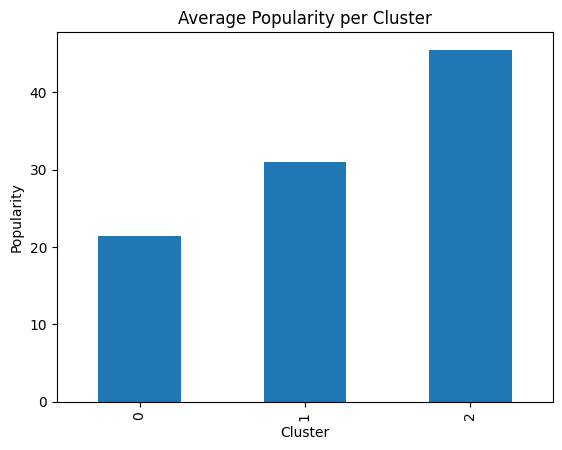

In [13]:
# add the cluster labels to the original dataframe
df['cluster'] = best_kmeans.labels_

# group by cluster and calculate the average popularity for each cluster
cluster_popularity = df.groupby('cluster')['popularity'].mean()
print(cluster_popularity)

# plot the average popularity per cluster
cluster_popularity.plot(kind='bar', title='Average Popularity per Cluster', ylabel='Popularity', xlabel='Cluster')
plt.show()


The bar plot shows the average popularity score for each cluster.
* Cluster 0 has the lowest average popularity (~21.49), indicating that the songs in this cluster tend to be less popular.
* Cluster 1 has a medium average popularity (~31.04), suggesting that the songs in this group are moderately popular.
* Cluster 2 has the highest average popularity (~45.50), implying that the songs in this cluster tend to be more popular.